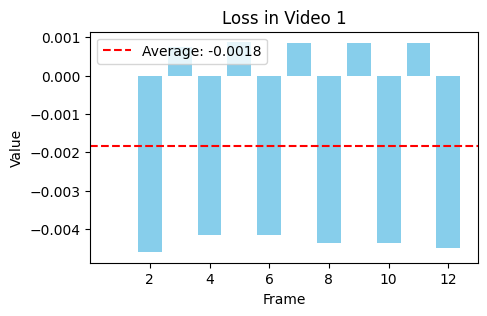

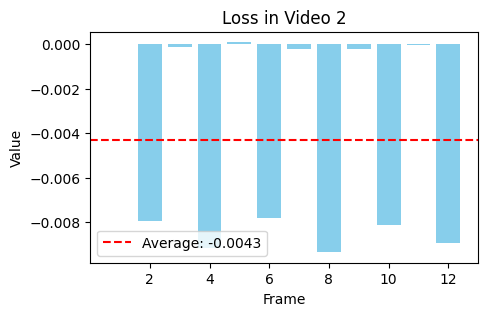

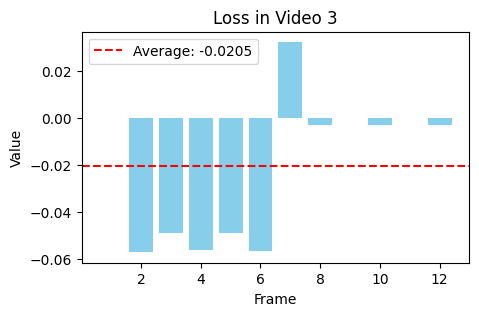

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

# 文件路径和标题映射
file_info = {
    "loss_list.txt": "Loss in Video 1",
    "loss_list2.txt": "Loss in Video 2",
    "loss_list3.txt": "Loss in Video 3"
}

# 定义一个函数读取文件并返回帧数和对应的数值列表
def read_file(file_path):
    frames = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(': ')
            if len(parts) == 2:
                frame = int(parts[0].replace("Frame ", ""))
                value = float(parts[1])
                frames.append(frame)
                values.append(value)
    return frames, values

# 绘制每个文件的柱状图
for file_path, title in file_info.items():
    frames, values = read_file(file_path)
    avg_value = np.mean(values)  # 计算平均值

    plt.figure(figsize=(5, 3))
    plt.bar(frames, values, color='skyblue')
    plt.axhline(y=avg_value, color='red', linestyle='--', label=f'Average: {avg_value:.4f}')
    plt.xlabel("Frame")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.show()


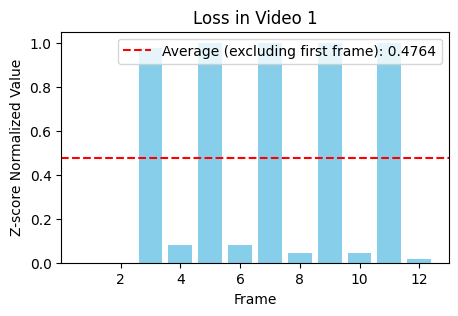

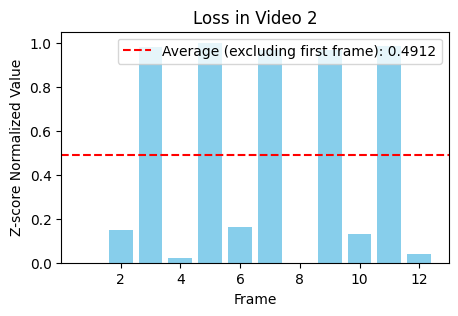

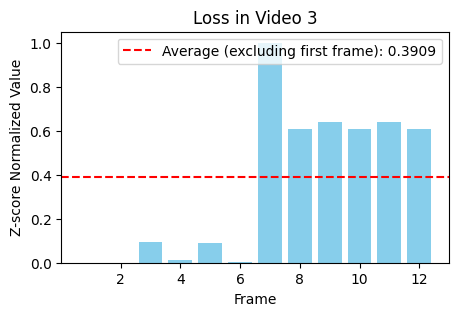

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# 文件路径和标题映射
file_info = {
    "loss_list.txt": "Loss in Video 1",
    "loss_list2.txt": "Loss in Video 2",
    "loss_list3.txt": "Loss in Video 3"
}

# 定义一个函数读取文件并返回帧数和 z-score 标准化后的值列表（保持第一帧不变）
def read_file_and_zscore(file_path):
    frames = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(': ')
            if len(parts) == 2:
                frame = int(parts[0].replace("Frame ", ""))
                value = float(parts[1])
                frames.append(frame)
                values.append(value)
    
    # 计算最小值和最大值（不包括第一帧）
    values_to_normalize = values[1:]
    min_value = np.min(values_to_normalize)
    max_value = np.max(values_to_normalize)

    # 计算 Min-Max 标准化后的值，将范围限制在 0 到 1
    normalized_values = [values[0]] + [(v - min_value) / (max_value - min_value) for v in values_to_normalize]
    
    return frames, normalized_values

# 绘制每个文件的柱状图
for file_path, title in file_info.items():
    frames, values = read_file_and_zscore(file_path)
    avg_value = np.mean(values[1:])  # 计算标准化后的平均值，不包括第一帧

    plt.figure(figsize=(5, 3))
    plt.bar(frames, values, color='skyblue')
    plt.axhline(y=avg_value, color='red', linestyle='--', label=f'Average (excluding first frame): {avg_value:.4f}')
    plt.xlabel("Frame")
    plt.ylabel("Z-score Normalized Value")
    plt.title(title)
    plt.legend()
    plt.show()


Frames in small loss distribution: [1, 2, 4, 6, 8, 10, 12]
Frames in large loss distribution: [3, 5, 7, 9, 11]


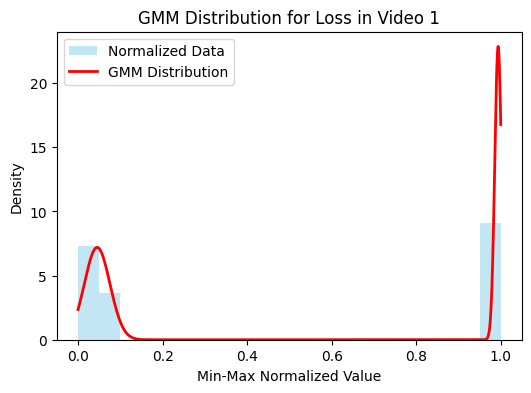

Frames in small loss distribution: [1, 2, 4, 6, 8, 10, 12]
Frames in large loss distribution: [3, 5, 7, 9, 11]


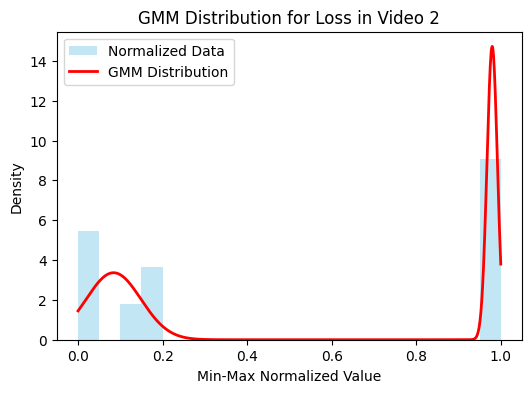

Frames in small loss distribution: [1, 2, 3, 4, 5, 6]
Frames in large loss distribution: [7, 8, 9, 10, 11, 12]


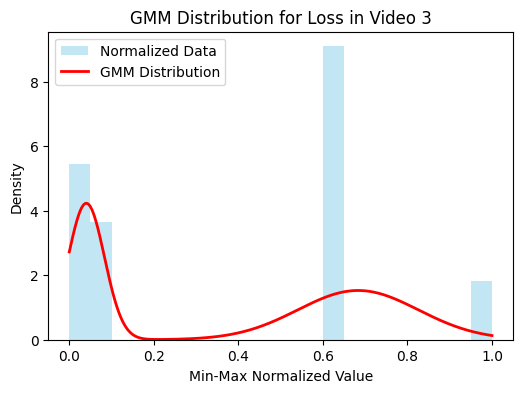

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

# File paths and titles
file_info = {
    "loss_list.txt": "Loss in Video 1",
    "loss_list2.txt": "Loss in Video 2",
    "loss_list3.txt": "Loss in Video 3"
}

# Function to read file and return frame numbers and Min-Max normalized values (keeping the first frame unchanged)
def read_file_and_minmax(file_path):
    frames = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(': ')
            if len(parts) == 2:
                frame = int(parts[0].replace("Frame ", ""))
                value = float(parts[1])
                frames.append(frame)
                values.append(value)
    
    # Min-Max normalization (excluding the first frame)
    values_to_normalize = values[1:]
    min_value = np.min(values_to_normalize)
    max_value = np.max(values_to_normalize)
    
    # Normalized values in range [0, 1]
    normalized_values = [values[0]] + [(v - min_value) / (max_value - min_value) for v in values_to_normalize]
    
    return frames, normalized_values

# Plot each file's bar chart and fit data into a GMM
for file_path, title in file_info.items():
    frames, values = read_file_and_minmax(file_path)
    
    # Fit GMM to normalized values (excluding the first frame)
    gmm_data = np.array(values[1:]).reshape(-1, 1)  # Reshape to 2D array
    gmm = GaussianMixture(n_components=2, random_state=0)  # Use 2 components
    gmm.fit(gmm_data)

    means = gmm.means_.flatten()
    large_component = np.argmax(means)

    # # Predict which distribution each frame belongs to
    # labels = gmm.predict(gmm_data)
    
    # # Separate frames based on distribution labels, adding the first frame to small loss frames
    # small_loss_frames = [frames[0]] + [frame for frame, label in zip(frames[1:], labels) if label == 0]
    # large_loss_frames = [frame for frame, label in zip(frames[1:], labels) if label == 1]

    probabilities = gmm.predict_proba(gmm_data)
    small_loss_frames = [frames[0]]  # 将第一帧添加到 small_loss_frames
    large_loss_frames=[]
    for frame, prob in zip(frames[1:], probabilities):
        if prob[large_component]>1-(1e-6):
            large_loss_frames.append(frame)
        else:
            small_loss_frames.append(frame)
    # Output the lists
    print("Frames in small loss distribution:", small_loss_frames)
    print("Frames in large loss distribution:", large_loss_frames)

    # Plot GMM distribution
    x = np.linspace(min(values[1:]), max(values[1:]), 1000).reshape(-1, 1)
    log_prob = gmm.score_samples(x)
    pdf = np.exp(log_prob)  # Compute probability density function

    plt.figure(figsize=(6, 4))
    plt.hist(gmm_data, bins=20, density=True, alpha=0.5, color='skyblue', label='Normalized Data')
    plt.plot(x, pdf, color='red', linewidth=2, label='GMM Distribution')
    plt.xlabel("Min-Max Normalized Value")
    plt.ylabel("Density")
    plt.title(f"GMM Distribution for {title}")
    plt.legend()
    plt.show()


Frames in small loss distribution: [1, 2, 4, 6, 8, 10, 12]
Frames in large loss distribution: [3, 5, 7, 9, 11]


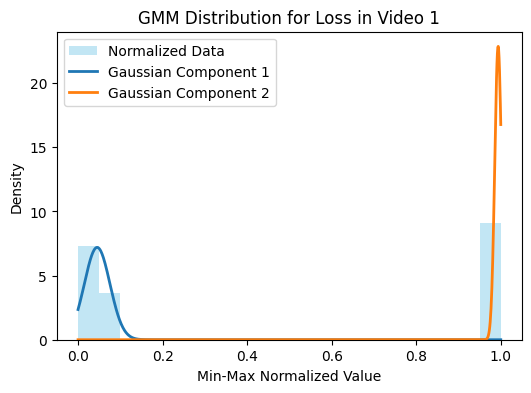

Frames in small loss distribution: [1, 2, 4, 6, 8, 10, 12]
Frames in large loss distribution: [3, 5, 7, 9, 11]


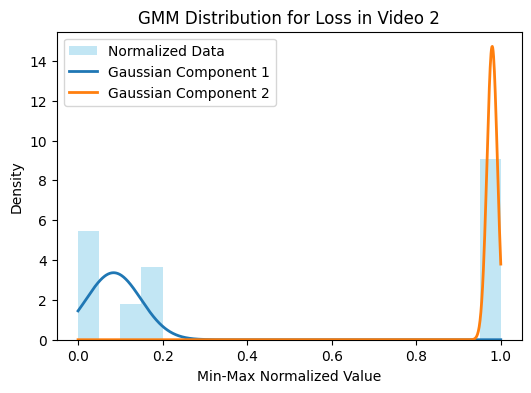

Frames in small loss distribution: [1, 2, 3, 4, 5, 6]
Frames in large loss distribution: [7, 8, 9, 10, 11, 12]


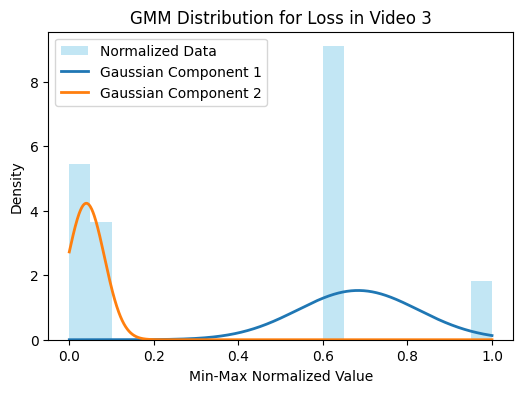

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

# File paths and titles
file_info = {
    "loss_list.txt": "Loss in Video 1",
    "loss_list2.txt": "Loss in Video 2",
    "loss_list3.txt": "Loss in Video 3"
}

# Function to read file and return frame numbers and Min-Max normalized values (keeping the first frame unchanged)
def read_file_and_minmax(file_path):
    frames = []
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(': ')
            if len(parts) == 2:
                frame = int(parts[0].replace("Frame ", ""))
                value = float(parts[1])
                frames.append(frame)
                values.append(value)
    
    # Min-Max normalization (excluding the first frame)
    values_to_normalize = values[1:]
    min_value = np.min(values_to_normalize)
    max_value = np.max(values_to_normalize)
    
    # Normalized values in range [0, 1]
    normalized_values = [values[0]] + [(v - min_value) / (max_value - min_value) for v in values_to_normalize]
    
    return frames, normalized_values

# Plot each file's bar chart and fit data into a GMM
for file_path, title in file_info.items():
    frames, values = read_file_and_minmax(file_path)
    
    # Fit GMM to normalized values (excluding the first frame)
    gmm_data = np.array(values[1:]).reshape(-1, 1)  # Reshape to 2D array
    gmm = GaussianMixture(n_components=2, random_state=0)  # Use 2 components
    gmm.fit(gmm_data)

    means = gmm.means_.flatten()
    large_component = np.argmax(means)

    # # Predict which distribution each frame belongs to
    # labels = gmm.predict(gmm_data)
    
    # # Separate frames based on distribution labels, adding the first frame to small loss frames
    # small_loss_frames = [frames[0]] + [frame for frame, label in zip(frames[1:], labels) if label == 0]
    # large_loss_frames = [frame for frame, label in zip(frames[1:], labels) if label == 1]

    probabilities = gmm.predict_proba(gmm_data)
    small_loss_frames = [frames[0]]  # 将第一帧添加到 small_loss_frames
    large_loss_frames=[]
    for frame, prob in zip(frames[1:], probabilities):
        if prob[large_component]>1-(1e-6):
            large_loss_frames.append(frame)
        else:
            small_loss_frames.append(frame)
    # Output the lists
    print("Frames in small loss distribution:", small_loss_frames)
    print("Frames in large loss distribution:", large_loss_frames)

    # Generate distribution plots
    x = np.linspace(min(values[1:]), max(values[1:]), 1000).reshape(-1, 1)
    # log_prob = gmm.score_samples(x)
    # pdf = np.exp(log_prob)  # Compute overall GMM probability density function

    plt.figure(figsize=(6, 4))
    plt.hist(gmm_data, bins=20, density=True, alpha=0.5, color='skyblue', label='Normalized Data')
    # plt.plot(x, pdf, color='red', linewidth=2, label='Overall GMM Distribution')

    # Plot each Gaussian component separately
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    weights = gmm.weights_.flatten()

    for i in range(2):  # Plot each Gaussian component
        mean = means[i]
        std_dev = np.sqrt(covariances[i])
        component_pdf = weights[i] * (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
        plt.plot(x, component_pdf, linewidth=2, label=f'Gaussian Component {i+1}')

    plt.xlabel("Min-Max Normalized Value")
    plt.ylabel("Density")
    plt.title(f"GMM Distribution for {title}")
    plt.legend()
    plt.show()
